In [1]:
from fynesse import access, assess, address

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tabulate import tabulate

In [2]:
from config import MODELS, EVENTS, SEEDS

SEEDS = 0, 42, 137

## Feature Construction

In [3]:
# load master dictionary for everything

master_dict = assess.eat_pickle(f'./data/pickle/master.pickle')

In [4]:
# choose your desired event combo

featured_events = ['fp_arith_inst_retired.256b_packed_single', 'fp_arith_inst_retired.512b_packed_single']
X = address.make_features(master_dict, featured_events, n_bins=32, models=MODELS, n_samples=100*len(SEEDS))

In [5]:
# feature scaling

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(MODELS)

y = list()
for model in MODELS:
    y += [model] * 100*len(SEEDS)
y = le.transform(y)

## PCA Visualization

/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


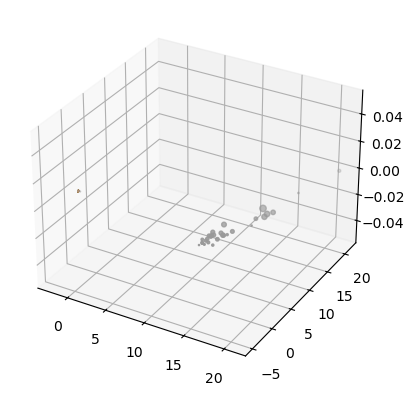

In [6]:
from sklearn.decomposition import PCA

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pca.fit(X)

X_pca = pca.transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y, cmap='Set1')
plt.show()

## Dataset Splitting

In [7]:
# split based on random seed value

X, X_test_unseen = address.seed_split(X, seed_idx=2, n_seeds=len(SEEDS))

In [8]:
# add labels

y = list()
for model in MODELS:
    y += [model] * (100*(len(SEEDS)-1))
y = le.transform(y)

y_test_unseen = list()
for model in MODELS:
    y_test_unseen += [model] * 100
y_test_unseen = le.transform(y_test_unseen)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## Utilities

In [10]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_results(cv_results_):
    print(tabulate(np.column_stack([cv_results_['params'], cv_results_['mean_test_score'], cv_results_['rank_test_score']]), headers=['params', 'score', 'rank']))

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(clf, X_test, y_test):
    accuracy = accuracy_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, clf.predict(X_test), average='macro')
    precision = precision_score(y_test, clf.predict(X_test), average='macro')
    recall = recall_score(y_test, clf.predict(X_test), average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

## $k$-NN

### Hyperparameter Tuning

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params = {'n_neighbors': [1,3,5,10],
          'weights': ['uniform','distance'],
          'p': [1,2,3]}

clf = GridSearchCV(knn, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [13]:
print_grid_search_results(clf.cv_results_)

params                                                 score    rank
--------------------------------------------------  --------  ------
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}    0.695556      23
{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}   0.695556      23
{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}    0.711111      17
{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}   0.711111      17
{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}    0.717778      14
{'n_neighbors': 1, 'p': 3, 'weights': 'distance'}   0.717778      14
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}    0.742222       2
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}   0.728889       9
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}    0.737778       6
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}   0.737778       5
{'n_neighbors': 3, 'p': 3, 'weights': 'uniform'}    0.728889       9
{'n_neighbors': 3, 'p': 3, 'weights': 'distance'}   0.733333       8
{'n_neighbors': 5, 'p': 1, 'weight

### Training

In [14]:
knn = KNeighborsClassifier(n_neighbors=10,
                           p=1,
                           weights='uniform')

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10, p=1)

### Evaluation

In [15]:
evaluate(knn, X_test, y_test)

Accuracy: 0.7666666666666667
F1: 0.7663132979964663
Precision: 0.7660530879018275
Recall: 0.7666666666666666


In [16]:
evaluate(knn, X_test_unseen, y_test_unseen)

Accuracy: 0.21666666666666667
F1: 0.24245466104530547
Precision: 0.383419689119171
Recall: 0.21666666666666665


## DT

### Hyperparameter Tuning

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

params = {'criterion': ['gini','entropy','log_loss'],
          'splitter': ['best', 'random'],
          'random_state': [42]}

clf = GridSearchCV(dt, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'random_state': [42], 'splitter': ['best', 'random']})

In [18]:
print_grid_search_results(clf.cv_results_)

params                                                                  score    rank
-------------------------------------------------------------------  --------  ------
{'criterion': 'gini', 'random_state': 42, 'splitter': 'best'}        0.751111       1
{'criterion': 'gini', 'random_state': 42, 'splitter': 'random'}      0.724444       4
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'best'}     0.733333       2
{'criterion': 'entropy', 'random_state': 42, 'splitter': 'random'}   0.691111       5
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'best'}    0.733333       2
{'criterion': 'log_loss', 'random_state': 42, 'splitter': 'random'}  0.691111       5


### Training

In [19]:
dt = DecisionTreeClassifier(criterion='entropy',
                            random_state=42,
                            splitter='random')

dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42, splitter='random')

### Evaluation

In [20]:
evaluate(dt, X_test, y_test)

Accuracy: 0.6666666666666666
F1: 0.6744704570791527
Precision: 0.6878306878306878
Recall: 0.6666666666666666


In [21]:
evaluate(dt, X_test_unseen, y_test_unseen)

Accuracy: 0.043333333333333335
F1: 0.04309861875784796
Precision: 0.08596491228070174
Recall: 0.043333333333333335


## RF

### Hyperparameter Tuning

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

params = {'n_estimators': [1, 5, 10, 25, 50, 100, 250, 500, 1000],
          'criterion': ['gini','entropy','log_loss'],
          'random_state': [42]}

clf = GridSearchCV(rf, params, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [1, 5, 10, 25, 50, 100, 250, 500,
                                          1000],
                         'random_state': [42]})

In [23]:
print_grid_search_results(clf.cv_results_)

params                                                                  score    rank
-------------------------------------------------------------------  --------  ------
{'criterion': 'gini', 'n_estimators': 1, 'random_state': 42}         0.717778      27
{'criterion': 'gini', 'n_estimators': 5, 'random_state': 42}         0.751111      21
{'criterion': 'gini', 'n_estimators': 10, 'random_state': 42}        0.733333      24
{'criterion': 'gini', 'n_estimators': 25, 'random_state': 42}        0.762222       7
{'criterion': 'gini', 'n_estimators': 50, 'random_state': 42}        0.753333      18
{'criterion': 'gini', 'n_estimators': 100, 'random_state': 42}       0.76          11
{'criterion': 'gini', 'n_estimators': 250, 'random_state': 42}       0.757778      15
{'criterion': 'gini', 'n_estimators': 500, 'random_state': 42}       0.76          11
{'criterion': 'gini', 'n_estimators': 1000, 'random_state': 42}      0.762222       7
{'criterion': 'entropy', 'n_estimators': 1, 'random_st

### Training

In [24]:
rf = RandomForestClassifier(criterion='gini',
                            n_estimators=100,
                            random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluation

In [25]:
evaluate(rf, X_test, y_test)

Accuracy: 0.7066666666666667
F1: 0.7041296556023063
Precision: 0.7159383252406508
Recall: 0.7066666666666667


In [26]:
evaluate(rf, X_test_unseen, y_test_unseen)

Accuracy: 0.023333333333333334
F1: 0.0362353695687029
Precision: 0.3367174280879865
Recall: 0.023333333333333334


## MLP

### Hyperparameter Tuning

In [27]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

params = {'hidden_layer_sizes': [[i+1] for i in range(10)],
          'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'solver': ['sgd', 'adam'],
          'learning_rate_init': [0.001, 0.005, 0.01],
          'max_iter': [1000, 2500, 5000],
          'momentum': [0.9, 0.99],
          'random_state': [42]}

clf = GridSearchCV(mlp, params, cv=5)
clf.fit(X_train, y_train)

/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/kate/anaconda3/envs/diss/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [[1], [2], [3], [4], [5], [6],
                                                [7], [8], [9], [10]],
                         'learning_rate_init': [0.001, 0.005, 0.01],
                         'max_iter': [1000, 2500, 5000],
                         'momentum': [0.9, 0.99], 'random_state': [42],
                         'solver': ['sgd', 'adam']})

In [28]:
print_grid_search_results(clf.cv_results_)

params                                                                                                                                                            score    rank
-------------------------------------------------------------------------------------------------------------------------------------------------------------  --------  ------
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.9, 'random_state': 42, 'solver': 'sgd'}     0.668889     938
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.9, 'random_state': 42, 'solver': 'adam'}    0.666667     980
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.99, 'random_state': 42, 'solver': 'sgd'}    0.666667     980
{'activation': 'identity', 'hidden_layer_sizes': [1], 'learning_rate_init': 0.001, 'max_iter': 1000, 'momentum': 0.99, '

### Training

In [29]:
mlp = MLPClassifier(activation='identity',
                    hidden_layer_sizes=[2], 
                    learning_rate_init=0.01,
                    max_iter=2500, 
                    momentum=0.99,
                    random_state=42,
                    solver='sgd')

mlp.fit(X_train, y_train)

MLPClassifier(activation='identity', hidden_layer_sizes=[2],
              learning_rate_init=0.01, max_iter=2500, momentum=0.99,
              random_state=42, solver='sgd')

### Evaluation

In [30]:
evaluate(mlp, X_test, y_test)

Accuracy: 0.6733333333333333
F1: 0.6651274980388905
Precision: 0.6948778343068902
Recall: 0.6733333333333333


In [31]:
evaluate(mlp, X_test_unseen, y_test_unseen)

Accuracy: 0.5266666666666666
F1: 0.4489470475118427
Precision: 0.40180102915951976
Recall: 0.5266666666666667
